# XGBoost

### Importing github repository

In [1]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
token = user_secrets.get_secret("token")

!git clone https://{token}@github.com/Benedart/RecSys-2022-Challenge-Polimi.git

Cloning into 'RecSys-2022-Challenge-Polimi'...
remote: Enumerating objects: 397, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 397 (delta 94), reused 163 (delta 63), pack-reused 203
Receiving objects: 100% (397/397), 343.25 MiB | 30.48 MiB/s, done.
Resolving deltas: 100% (129/129), done.


#### Compiling Cython files

In [2]:
import os

os.chdir( "./RecSys-2022-Challenge-Polimi")
!python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorization_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969,
                 from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from MatrixFactorization_Cython_Epoch.c:746:
/opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorization_Cython_Epoch.c: In function ‘__pyx_pf_32MatrixFactorization_Cyth

In [3]:
!cp -r /kaggle/input/recsyslight/result_experiments/SKOPT_test/ result_experiments/SKOPT_test/

os.chdir("result_experiments/SKOPT_test")
! for i in */; do (cd "$i"; zip -r "../${i%/}.zip" .); done
! rm -R -- */
os.chdir("../..")

  adding: time_df.h5 (deflated 100%)
  adding: cutoff_to_optimize.json (stored 0%)
  adding: .result_on_validation_df.csv (deflated 56%)
  adding: metric_to_optimize.json (stored 0%)
  adding: time_on_train_total.json (stored 0%)
  adding: time_on_validation_total.json (stored 0%)
  adding: exception_list.json (deflated 96%)
  adding: .time_on_last_df.csv (stored 0%)
  adding: .result_on_test_best.csv (deflated 49%)
  adding: result_on_validation_df.h5 (deflated 99%)
  adding: .time_df.csv (deflated 47%)
  adding: algorithm_name_recommender.json (stored 0%)
  adding: .result_on_last.csv (deflated 49%)
  adding: time_on_test_total.json (stored 0%)
  adding: result_on_validation_best.json (deflated 53%)
  adding: hyperparameters_df.h5 (deflated 100%)
  adding: result_on_test_best.h5 (deflated 100%)
  adding: hyperparameters_best_index.json (stored 0%)
  adding: result_on_earlystopping_df.json (stored 0%)
  adding: .result_on_test_df.csv (deflated 63%)
  adding: time_on_validation_avg.jso

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.sparse as sps
import csv
import xgboost as xgb

from Recommenders.Recommender_import_list import *

#### Importing URM & ICM

In [7]:
URM_all = pd.read_csv("/kaggle/input/recommender-system-2022-challenge-polimi/interactions_and_impressions.csv")
ICM_type = pd.read_csv("/kaggle/input/recommender-system-2022-challenge-polimi/data_ICM_type.csv")
ICM_length = pd.read_csv("/kaggle/input/recommender-system-2022-challenge-polimi/data_ICM_length.csv")

ICM_all = pd.concat([ICM_type, ICM_length]).sort_values(by='item_id')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
URM_all

,UserID,ItemID,Impressions,Data
0,0,11,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19",1
1,0,21,NaN,0
2,0,21,NaN,0
3,0,21,"20,21,22,23,24,25,26,27,28,29",0
4,0,21,NaN,1
...,...,...,...,...
5826501,41628,20448,NaN,0
5826502,41628,20896,NaN,1
5826503,41628,21506,NaN,1
5826504,41628,22882,NaN,0


In [9]:
ICM_all

,item_id,feature_id,data
0,0,1,1
0,0,0,1
1,1,0,1
1,1,3,1
2,2,4,1
...,...,...,...
23088,27965,1,1
23089,27966,0,1
23089,27966,1,1
23090,27967,4,1


#### Getting rid of duplicates and empty indices
Let's start with the indices, the mapping is done for consistency

In [10]:
mapped_id, original_id = pd.factorize(URM_all["UserID"].unique())
user_original_Id_to_index = pd.Series(mapped_id, index=original_id)

print("Unique UserID in the URM are {}".format(len(original_id)))

mapped_id, original_id = pd.factorize(URM_all["ItemID"].unique())

print("Unique ItemID in the URM are {}".format(len(original_id)))

all_item_indices = pd.concat([URM_all["ItemID"], ICM_all["item_id"]], ignore_index=True)
mapped_id, original_id = pd.factorize(all_item_indices.unique())

print("Unique ItemID in the URM and ICM are {}".format(len(original_id)))

item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(ICM_all["feature_id"].unique())
feature_original_ID_to_index = pd.Series(mapped_id, index=original_id)

print("Unique FeatureID in the URM are {}".format(len(feature_original_ID_to_index)))

URM_all["UserID"] = URM_all["UserID"].map(user_original_Id_to_index)
URM_all["ItemID"] = URM_all["ItemID"].map(item_original_ID_to_index)
ICM_all["item_id"] = ICM_all["item_id"].map(item_original_ID_to_index)
ICM_all["feature_id"] = ICM_all["feature_id"].map(feature_original_ID_to_index)

Unique UserID in the URM are 41629
Unique ItemID in the URM are 24507
Unique ItemID in the URM and ICM are 27968
Unique FeatureID in the URM are 6


And then we remove duplicate values

In [11]:
URM_all = URM_all.drop(["Impressions", "Data"], axis=1).drop_duplicates()
URM_all["Rating"] = 1
ICM_all = ICM_all.drop_duplicates()

In [12]:
URM_all

,UserID,ItemID,Rating
0,0,0,1
1,0,1,1
13,0,2,1
28,0,3,1
29,0,4,1
...,...,...,...
5826501,41628,3700,1
5826502,41628,12694,1
5826503,41628,15132,1
5826504,41628,18128,1


In [13]:
ICM_all

,item_id,feature_id,data
0,3668,0,1
0,3668,1,1
1,1945,1,1
1,1945,2,1
2,18373,3,1
...,...,...,...
23088,27965,0,1
23089,27966,1,1
23089,27966,0,1
23090,27967,3,1


#### Creating the matrices

In [14]:
n_users = len(user_original_Id_to_index)
n_items = len(item_original_ID_to_index)
n_features = len(feature_original_ID_to_index)

from sklearn.model_selection import train_test_split

seed = 42

(user_ids_training_validation, user_ids_test,
 item_ids_training_validation, item_ids_test,
 ratings_training_validation, ratings_test) = train_test_split(URM_all.UserID,
                                                    URM_all.ItemID,
                                                    URM_all.Rating,
                                                    test_size=0.15,
                                                    shuffle=True,
                                                    random_state=seed)

(user_ids_training, user_ids_validation,
 item_ids_training, item_ids_validation,
 ratings_training, ratings_validation) = train_test_split(user_ids_training_validation,
                                                          item_ids_training_validation,
                                                          ratings_training_validation,
                                                          test_size=0.15,
                                                          shuffle=True,
                                                          random_state=seed)

URM_all = sps.csr_matrix((URM_all.Rating, (URM_all.UserID, URM_all.ItemID)),
                           shape = (n_users, n_items))

URM_train = sps.csr_matrix((ratings_training, (user_ids_training, item_ids_training)),
                           shape = (n_users, n_items))

URM_validation = sps.csr_matrix((ratings_validation, (user_ids_validation, item_ids_validation)),
                           shape = (n_users, n_items))

URM_train_validation = sps.csr_matrix((ratings_training_validation, (user_ids_training_validation, item_ids_training_validation)),
                           shape = (n_users, n_items))

URM_test = sps.csr_matrix((ratings_test, (user_ids_test, item_ids_test)),
                           shape = (n_users, n_items))


ICM_all = sps.csr_matrix((np.ones(len(ICM_all["item_id"].values)), 
                          (ICM_all["item_id"].values, ICM_all["feature_id"].values)),
                        shape = (n_items, n_features))

ICM_all.data = np.ones_like(ICM_all.data)

ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

#### Setting up evaluators

In [15]:
from Evaluation.Evaluator import EvaluatorHoldout

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 1520 ( 3.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 976 ( 2.3%) Users that have less than 1 test interactions


### Creating the hybrid recommender

In [14]:
SLIM_Elastic = SLIMElasticNetRecommender(URM_train_validation)
SLIM_Elastic.fit(
    topK= 3754, 
    l1_ratio= 0.00024390416925243038, 
    alpha= 0.0023677660177288105
)

SLIMElasticNetRecommender: URM Detected 3461 (12.4%) items with no interactions.
SLIMElasticNetRecommender: Processed 3902 (14.0%) in 5.00 min. Items per second: 13.00
SLIMElasticNetRecommender: Processed 8276 (29.6%) in 10.00 min. Items per second: 13.79
SLIMElasticNetRecommender: Processed 12772 (45.7%) in 15.00 min. Items per second: 14.19
SLIMElasticNetRecommender: Processed 17320 (61.9%) in 20.00 min. Items per second: 14.43
SLIMElasticNetRecommender: Processed 22007 (78.7%) in 25.00 min. Items per second: 14.67
SLIMElasticNetRecommender: Processed 24862 (88.9%) in 30.00 min. Items per second: 13.81
SLIMElasticNetRecommender: Processed 25600 (91.5%) in 35.01 min. Items per second: 12.19
SLIMElasticNetRecommender: Processed 26327 (94.1%) in 40.01 min. Items per second: 10.97
SLIMElasticNetRecommender: Processed 27061 (96.8%) in 45.01 min. Items per second: 10.02
SLIMElasticNetRecommender: Processed 27811 (99.4%) in 50.02 min. Items per second: 9.27
SLIMElasticNetRecommender: Proces

In [18]:
SLIM_Elastic = SLIMElasticNetRecommender(URM_train_validation)
SLIM_Elastic.load_model('.', 'SLIM_Elastic_model.zip')

SLIMElasticNetRecommender: URM Detected 3461 (12.4%) items with no interactions.
SLIMElasticNetRecommender: Loading model from file '.SLIM_Elastic_model.zip'
SLIMElasticNetRecommender: Loading complete


In [19]:
RP3Beta = RP3betaRecommender(URM_train_validation)
RP3Beta.fit(
    topK= 85,
    alpha= 0.6816904984217647, 
    beta= 0.19475226184133623,
    normalize_similarity= True
)

RP3betaRecommender: URM Detected 3461 (12.4%) items with no interactions.
RP3betaRecommender: Similarity column 27968 (100.0%), 1993.22 column/sec. Elapsed time 14.03 sec


In [20]:
ItemKNN_CFCBF = ItemKNN_CFCBF_Hybrid_Recommender(URM_train_validation, ICM_all)
ItemKNN_CFCBF.fit(
    topK= 22, 
    shrink= 67, 
    similarity= 'tversky', 
    normalize= True, 
    tversky_alpha= 0.40023516816210714, 
    tversky_beta= 2.6764289411219835, 
    ICM_weight= 1.116245673194657
)

ItemKNN_CFCBF_HybridRecommender: URM Detected 3461 (12.4%) items with no interactions.
ItemKNN_CFCBF_HybridRecommender: ICM Detected 4877 (17.4%) items with no features.
Similarity column 27968 (100.0%), 1406.21 column/sec. Elapsed time 19.89 sec


In [21]:
recommenders = [SLIM_Elastic, RP3Beta] 
alphas = [1.448319796422743, 0.907322766936059]

recommender = GeneralizedLinearHybridRecommender(
    URM_train = URM_train_validation, 
    recommenders=recommenders
)

recommender.fit(alphas)

SLIMElasticNetRP3betaHybridRecommender: URM Detected 3461 (12.4%) items with no interactions.


In [17]:
recommender.save_model('.', file_name='hybrid_train_validation.zip')

In [22]:
evaluator_test.evaluateRecommender(recommender)

EvaluatorHoldout: Processed 40653 (100.0%) in 1.22 min. Users per second: 553


(       PRECISION PRECISION_RECALL_MIN_DEN    RECALL       MAP MAP_MIN_DEN  \
 cutoff                                                                      
 10      0.055573                 0.093076  0.086997  0.027515    0.045018   
 
              MRR      NDCG        F1  HIT_RATE ARHR_ALL_HITS  ...  \
 cutoff                                                        ...   
 10      0.182542  0.089344  0.067822  0.363442      0.222469  ...   
 
        COVERAGE_USER COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI  \
 cutoff                                                              
 10          0.976555          0.354921    0.976555       0.016538   
 
        SHANNON_ENTROPY RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI  \
 cutoff                                                                   
 10            8.844562                   0.993964             0.037105   
 
        RATIO_SHANNON_ENTROPY RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
 cutoff                                   

### Let's build the dataframe with the predictions

In [32]:
URM_all

<41629x27968 sparse matrix of type '<class 'numpy.int64'>'
	with 1554640 stored elements in Compressed Sparse Row format>

In [34]:
cutoff = 20
user_recommendations_items = []
user_recommendations_user_id = []

for id in target['id']:
    # getting the recommendations
    recommendations = recommender.recommend(user_id_array=id, remove_seen_flag=True, cutoff=cutoff)
    
    """
    # retrieving the original ids for each recommended item
    recommendations_original_ids = []
    for rec in recommendations:
        recommendations_original_ids.append(item_original_ID_to_index[item_original_ID_to_index==rec].index.item())
    """
    user_recommendations_items.extend(recommendations)
    # retrieving the original ids of the user
    user_recommendations_user_id.extend([id]*len(recommendations))

In [35]:
train_dataframe = pd.DataFrame({"user_id":user_recommendations_user_id, "item_id":user_recommendations_items})
train_dataframe

,user_id,item_id
0,0,2
1,0,108
2,0,175
3,0,111
4,0,343
...,...,...
822315,41628,1670
822316,41628,403
822317,41628,12124
822318,41628,1259


#### Now let's add some features. For example, the prediction of another algorithm

In [36]:
topPop = TopPop(URM_train_validation)
topPop.fit()

topPop_score_list = []

for user_id, item_id in zip(user_recommendations_user_id, user_recommendations_items):
    topPop_score = topPop._compute_item_score([user_id])[0,item_id]
    topPop_score_list.append(topPop_score)

TopPopRecommender: URM Detected 3461 (12.4%) items with no interactions.


In [37]:
train_dataframe['item_popularity'] = pd.Series(topPop_score_list, index=train_dataframe.index)
train_dataframe

,user_id,item_id,item_popularity
0,0,2,5085.0
1,0,108,585.0
2,0,175,1144.0
3,0,111,557.0
4,0,343,3643.0
...,...,...,...
822315,41628,1670,1286.0
822316,41628,403,755.0
822317,41628,12124,39.0
822318,41628,1259,1152.0


#### Or the profile length

In [38]:
user_profile_len = np.ediff1d(URM_train_validation.indptr)

In [39]:
user_profile_len_list = []
target_feature = 1

for user_id, item_id in zip(user_recommendations_user_id, user_recommendations_items):
    user_profile_len_list.append(user_profile_len[user_id])

In [40]:
train_dataframe['user_profile_len'] = pd.Series(user_profile_len_list, index=train_dataframe.index)
train_dataframe

,user_id,item_id,item_popularity,user_profile_len
0,0,2,5085.0,54
1,0,108,585.0,54
2,0,175,1144.0,54
3,0,111,557.0,54
4,0,343,3643.0,54
...,...,...,...,...
822315,41628,1670,1286.0,23
822316,41628,403,755.0,23
822317,41628,12124,39.0,23
822318,41628,1259,1152.0,23


### and also item features

In [65]:
ICM_length[ICM_length['item_id'] == 111].data.values.size

1

In [66]:
length_list = []

for user_id, item_id in zip(user_recommendations_user_id, user_recommendations_items):
    if ICM_length[ICM_length['item_id'] == item_id].data.values.size == 1:
        length_list.append(ICM_length[ICM_length['item_id'] == item_id].data.values[0])
    else:
        length_list.append(0)

In [67]:
train_dataframe['item_length'] = pd.Series(length_list, index=train_dataframe.index)
train_dataframe

,user_id,item_id,item_popularity,user_profile_len,item_length
0,0,2,5085.0,54,21
1,0,108,585.0,54,1
2,0,175,1144.0,54,1
3,0,111,557.0,54,26
4,0,343,3643.0,54,0
...,...,...,...,...,...
822315,41628,1670,1286.0,23,1
822316,41628,403,755.0,23,0
822317,41628,12124,39.0,23,15
822318,41628,1259,1152.0,23,0


In [82]:
type_list = []

for user_id, item_id in zip(user_recommendations_user_id, user_recommendations_items):
    if ICM_type[ICM_type['item_id'] == item_id].feature_id.values.size == 1:
        type_list.append(ICM_type[ICM_type['item_id'] == item_id].feature_id.values[0])
    else:
        type_list.append(0)

In [83]:
train_dataframe['item_type'] = pd.Series(type_list, index=train_dataframe.index)
train_dataframe

,user_id,item_id,item_popularity,user_profile_len,item_length,item_type
0,0,2,5085.0,54,21,4
1,0,108,585.0,54,1,1
2,0,175,1144.0,54,1,1
3,0,111,557.0,54,26,4
4,0,343,3643.0,54,0,0
...,...,...,...,...,...,...
822315,41628,1670,1286.0,23,1,3
822316,41628,403,755.0,23,0,0
822317,41628,12124,39.0,23,15,4
822318,41628,1259,1152.0,23,0,0


### Adding the target array

In [93]:
target = []
count = 0

for user_id, item_id in zip(user_recommendations_user_id, user_recommendations_items):
    target.append(1 if count%cutoff < 10 else 0)
    count = count + 1

In [94]:
target

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


## Let's try BOOSTING
Use DMatrix as data structures for both train and test.

DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed. You can construct DMatrix from numpy.arrays:

In [95]:
dtrain = xgb.DMatrix(train_dataframe, label=target)
# dtest = xgb.DMatrix(URM_test)

Set XGBoost parameters:

In [96]:
params = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # step for each iteration
    'silent': 1, # keep it quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2, # the number of classes 
    'eval_metric': 'merror'} # evaluation metric 

num_round = 20  # the number of training iterations (number of trees)

Create a model and fit it with params:

In [97]:
model = xgb.train(params,
                  dtrain,
                  num_round,
                  verbose_eval=2,
                  evals=[(dtrain, 'train')])

[16:00:36] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-merror:0.43898
[2]	train-merror:0.43824
[4]	train-merror:0.43700
[6]	train-merror:0.43334
[8]	train-merror:0.43014
[10]	train-merror:0.42965
[12]	train-merror:0.42855
[14]	train-merror:0.42591
[16]	train-merror:0.42267
[18]	train-merror:0.41913
[19]	train-merror:0.41913


In [ ]:
from sklearn.metrics import precision_score

preds = model.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])
print("Precision: {:.2f} %".format(precision_score(y_test, best_preds, average='macro')))

## Let's check the importance of each feature

In [99]:
%matplotlib inline
from xgboost import plot_importance

**Gain**: it implies the relative contribution of the corresponding feature to the model calculated by taking each feature's contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction.

<AxesSubplot:title={'center':'Gain'}, xlabel='F score', ylabel='Features'>

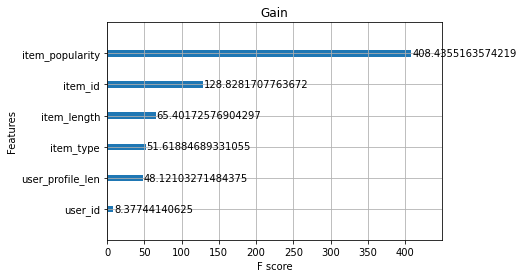

In [100]:
plot_importance(model, importance_type='gain', title='Gain')

**Cover**: The Cover metric means the relative number of observations related to this feature. Therefore is the number of observations for which the leaf node is determined by the feature. This number will be calculated for all the features in the dataset and the cover will be expressed as a percentage over all features' cover metrics.

<AxesSubplot:title={'center':'Cover'}, xlabel='F score', ylabel='Features'>

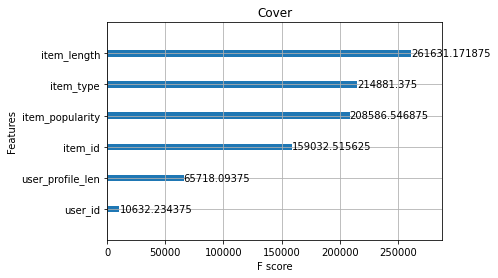

In [101]:
plot_importance(model, importance_type='cover', title='Cover')

**Weight (Frequence)**: is the percentage representing the relative number of times a particular feature occurs in the trees of the model. Is the number of splits in which the particular feature occurred.

<AxesSubplot:title={'center':'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

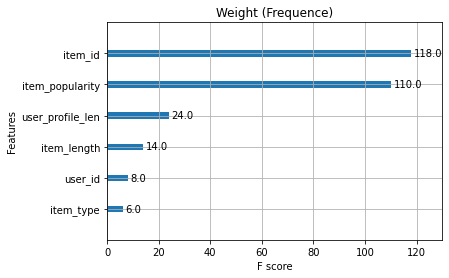

In [102]:
plot_importance(model, importance_type='weight', title='Weight (Frequence)')

### Let's try with the validation split

In [107]:
X_train, X_val, y_train, y_val = train_test_split(train_dataframe, target, test_size=0.2, random_state=3)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [109]:
params = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # step for each iteration
    'silent': 1, # keep it quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2, # the number of classes 
    'eval_metric': 'merror'} # evaluation metric 

num_round = 1000  # the number of training iterations (number of trees)

In [110]:
model = xgb.train(params,
                  dtrain,
                  num_round,
                  verbose_eval=2,
                  evals=[(dtrain, 'train'), (dval, 'validation')],
                  early_stopping_rounds=20)

[16:35:24] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-merror:0.43858	validation-merror:0.44055
[2]	train-merror:0.43788	validation-merror:0.43966
[4]	train-merror:0.43660	validation-merror:0.43861
[6]	train-merror:0.43376	validation-merror:0.43577
[8]	train-merror:0.42901	validation-merror:0.43115
[10]	train-merror:0.42606	validation-merror:0.42771
[12]	train-merror:0.42615	validation-merror:0.42845
[14]	train-merror:0.42362	validation-merror:0.42625
[16]	train-merror:0.42089	validation-merror:0.42369
[18]	train-merror:0.42085	validation-merror:0.42366
[20]	train-merror:0.41998	validation-merror:0.42311
[22]	train-merror:0.41855	validation-merror:0.42150
[24]	train-merror:0.4184

<AxesSubplot:title={'center':'Gain'}, xlabel='F score', ylabel='Features'>

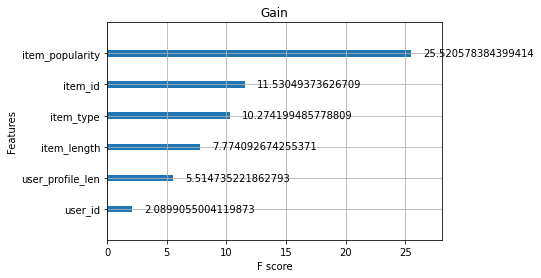

In [112]:
plot_importance(model, importance_type='gain', title='Gain')

<AxesSubplot:title={'center':'Cover'}, xlabel='F score', ylabel='Features'>

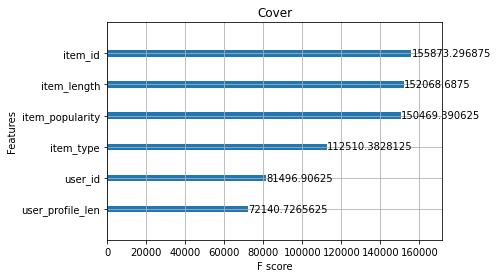

In [113]:
plot_importance(model, importance_type='cover', title='Cover')

<AxesSubplot:title={'center':'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

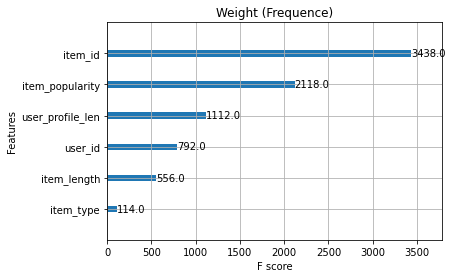

In [111]:
plot_importance(model, importance_type='weight', title='Weight (Frequence)')

### Random tries

In [115]:
from sklearn.metrics import accuracy_score

#### Wait what do I use for testing?
Let's use again the training df since I haven't got any test split 😎<br>Surely it will be a good idea

In [134]:
preds = model.predict(dtrain, iteration_range=(0, model.best_iteration + 1))
train_labels = dtrain.get_label()
train_labels[:10]
toppreds = np.argmax(preds,axis=1)
print("Accuracy: {}".format(accuracy_score(train_labels,toppreds)))

Accuracy: 0.6152683870026268


In [143]:
preds

array([[0.30554706, 0.69445294],
       [0.40963316, 0.59036684],
       [0.5942799 , 0.4057201 ],
       ...,
       [0.66318727, 0.33681273],
       [0.515488  , 0.48451197],
       [0.51957524, 0.48042473]], dtype=float32)

That's not what I expected :D

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

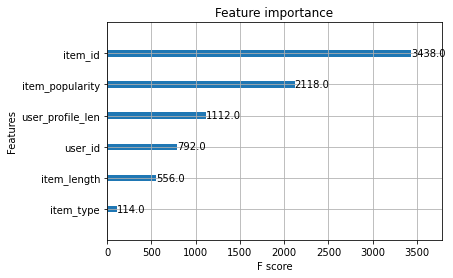

In [129]:
xgb.plot_importance(model)

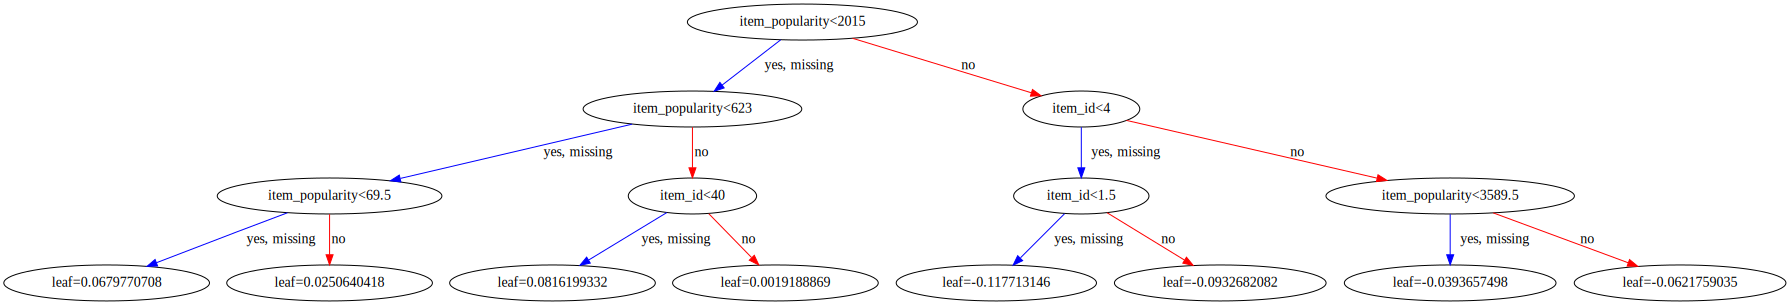

In [133]:
xgb.to_graphviz(model, num_trees=2)

In [ ]:
print("Testing random entry:")
topNvalue = 10
n = np.random.choice(len(train_labels))
a = preds[n,:]
topN=np.argpartition(preds,-topNvalue)[:,-topNvalue:]
print("Actual: {}".format(train_labels[n]))
print("Top: {}".format(toppreds[n]))
print("Top 10 Predictions: {}".format(topN[n,]))

# Get the accuracy in the top N results
acc=float(topN.size - np.count_nonzero((topN.transpose() - train_labels).transpose()))/len(train_labels)
print("In-sample accuracy: {}".format(acc))   